In [1]:
import pandas as pd
import numpy as np

#import xgboost as xgb
import re
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

In [2]:
# Считываем данные
tr_mcc_codes = pd.read_csv('./data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('./data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('./data/transactions.csv', index_col='customer_id')
transactions.describe()

,mcc_code,tr_type,amount
count,6.849346e+06,6.849346e+06,6.849346e+06
mean,5.589776e+03,2.517356e+03,-2.054285e+04
std,6.035857e+02,2.270108e+03,4.777528e+05
min,7.420000e+02,1.000000e+03,-1.459845e+08
25%,5.200000e+03,1.030000e+03,-2.245916e+04
50%,5.641000e+03,1.110000e+03,-5.480030e+03
75%,6.010000e+03,2.370000e+03,-1.122960e+03
max,9.402000e+03,8.146000e+03,1.459845e+08


In [4]:
gender_train = pd.read_csv('./data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))
# gender_test = pd.read_csv('./data/gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [5]:
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


In [6]:
# Добавим дополнительные признаки по каждому пользователю в модель.
# Для этого будем анализировать дни недели, часы и состояние дня/ночи.
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample

<bound method NDFrame.sample of               tr_datetime  mcc_code  tr_type     amount   term_id  gender  \
customer_id                                                                 
22899          1 15:26:45      4814     1030   -4491.83       NaN       1   
22899          2 20:52:48      4814     1030   -2245.92       NaN       1   
22899          5 18:52:19      6011     2010  -44918.32       NaN       1   
22899          6 12:28:22      6011     2010 -150476.36       NaN       1   
22899         28 10:41:01      6010     7030   33688.74       NaN       1   
...                   ...       ...      ...        ...       ...     ...   
99999680     444 00:00:00      5411     1110   -5659.71  31190432       1   
99999680     444 00:00:00      6011     2110 -134754.95    406826       1   
99999680     446 00:00:00      5541     1110  -11229.58   J038003       1   
99999680     451 09:56:17      6010     7070    1122.96    945022       1   
99999680     456 06:28:00      4814     1030

In [7]:
def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    # ВременнЫе признаки
    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    # Стандартные агрегации, посчитанные на расходах и приходах клиента: 
    # минимум, максимум, среднее, медиана, среднеквадратичное отклонение, количество
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    # Типы транзакций 
    #features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    # Типы mcc кодов
    #features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    # ДОПОЛНИТЕЛЬНЫЕ ПАРАМЕТРЫ
    # ....
    
    return pd.concat(features)

In [7]:
import pandas as pd

# Загрузка данных из CSV файлов
df_transactions = pd.read_csv('./data/transactions.csv')
df_gender = pd.read_csv('./data/gender_train.csv')

# Объединение данных по customer_id
merged_df = pd.merge(df_transactions[['customer_id', 'mcc_code']], df_gender, on='customer_id')

# Сохранение результата в новый CSV файл
merged_df.to_csv('result.csv', index=False)


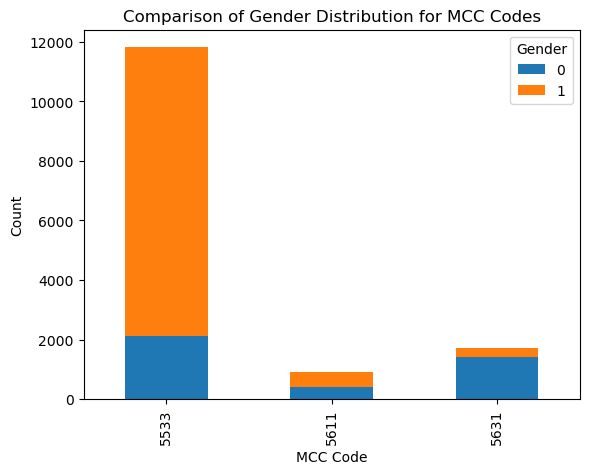

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('result.csv')

# Список интересующих mcc_code
mcc_codes_of_interest = [5631, 5611, 5533]  # Добавьте новые mcc_code по необходимости

# Создание DataFrame с интересующими mcc_code
all_mcc_codes_df = pd.DataFrame({'mcc_code': mcc_codes_of_interest})

# Объединение данных с интересующими mcc_code
df_filtered = pd.merge(all_mcc_codes_df, df, how='left', on='mcc_code')

# Группировка данных по mcc_code и gender, а затем подсчет количества
grouped_data = df_filtered.groupby(['mcc_code', 'gender']).size().unstack(fill_value=0)

# Построение графика
grouped_data.plot(kind='bar', stacked=True)
plt.title('Comparison of Gender Distribution for MCC Codes')
plt.xlabel('MCC Code')
plt.ylabel('Count')
plt.legend(title='Gender', loc='upper right')
plt.show()

5631 - Аксессуары для женщин<br />
5611 - Мужская одежда и аксессуары, включая одежду для мальчиков<br />
5533 - Автозапчасти и аксессуары<br />
**0 - Женский пол**<br />
**1 - Мужской пол**

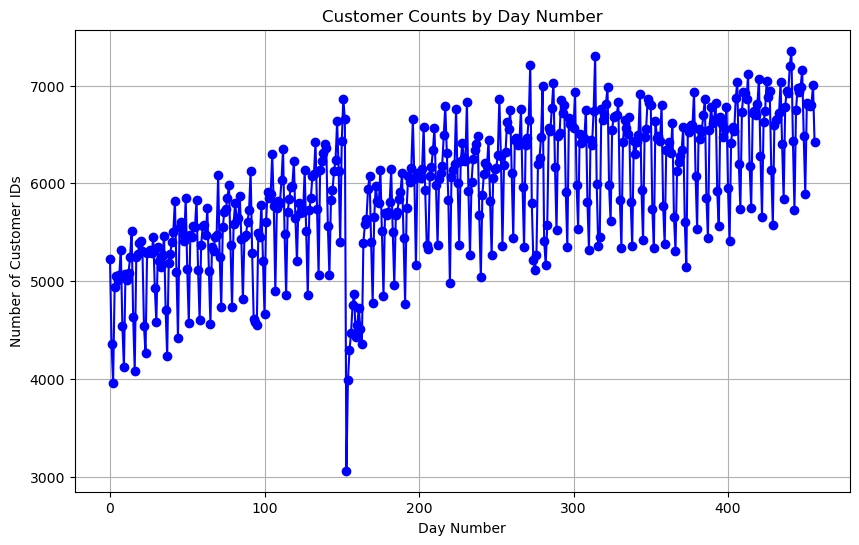

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Извлечение числа до пробела в 'tr_datetime'
df['day_number'] = df['tr_datetime'].apply(lambda x: int(x.split()[0]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df.groupby('day_number')['customer_id'].nunique()

# Построение графика
plt.figure(figsize=(10, 6))
daily_customer_counts.plot(marker='o', linestyle='-', color='b')
plt.title('Customer Counts by Day Number')
plt.xlabel('Day Number')
plt.ylabel('Number of Customer IDs')
plt.grid(True)
plt.show()



In [66]:
import pandas as pd

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Извлечение числа до пробела в 'tr_datetime'
df['day_number'] = df['tr_datetime'].apply(lambda x: int(x.split()[0]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df.groupby('day_number')['customer_id'].nunique()

# Нахождение номера с наибольшим количеством customer_id
max_day_number = daily_customer_counts.idxmax()

# Нахождение номера с наименьшим количеством customer_id
min_day_number = daily_customer_counts.idxmin()

print(f'Day number with the maximum number of customer_id: {max_day_number}')
print(f'Day number with the minimum number of customer_id: {min_day_number}')

Day number with the maximum number of customer_id: 441
Day number with the minimum number of customer_id: 153


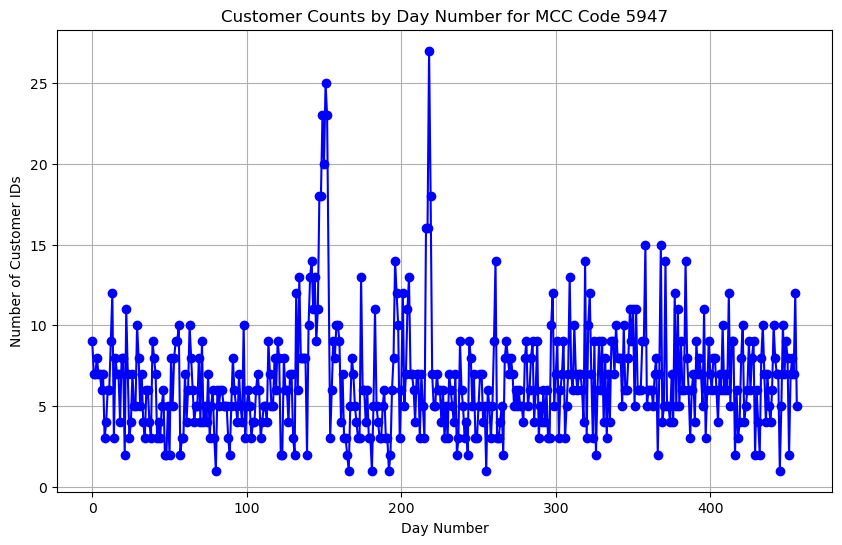

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Укажите нужный mcc_code
selected_mcc_code = 5947

# Фильтрация данных по выбранному mcc_code
df_filtered = df[df['mcc_code'] == selected_mcc_code]

# Извлечение числа до пробела в 'tr_datetime'
df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df_filtered.groupby('day_number')['customer_id'].nunique()

# Построение графика
plt.figure(figsize=(10, 6))
daily_customer_counts.plot(marker='o', linestyle='-', color='b')
plt.title(f'Customer Counts by Day Number for MCC Code {selected_mcc_code}')
plt.xlabel('Day Number')
plt.ylabel('Number of Customer IDs')
plt.grid(True)
plt.show()


In [72]:
import pandas as pd

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Укажите нужный mcc_code
selected_mcc_code = 5947

# Фильтрация данных по выбранному mcc_code
df_filtered = df[df['mcc_code'] == selected_mcc_code]

# Извлечение числа до пробела в 'tr_datetime'
df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df_filtered.groupby('day_number')['customer_id'].nunique()

# Нахождение трех номеров с наибольшим количеством customer_id
top3_days = daily_customer_counts.nlargest(3)

print(f'Top 3 day numbers with the maximum number of customer_id for MCC Code {selected_mcc_code}:')
for rank, day_number in enumerate(top3_days.index, 1):
    print(f'Rank {rank}: Day Number {day_number} - {top3_days[day_number]} customer_id')




Top 3 day numbers with the maximum number of customer_id for MCC Code 5947:
Rank 1: Day Number 218 - 27 customer_id
Rank 2: Day Number 151 - 25 customer_id
Rank 3: Day Number 149 - 23 customer_id


**153 день - 1 января четверг**

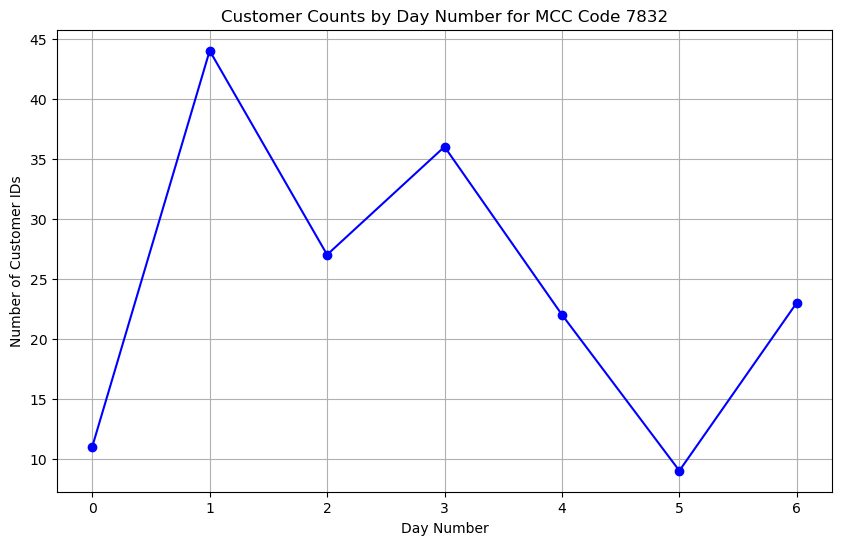

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Укажите нужный mcc_code
selected_mcc_code = 7832

# Фильтрация данных по выбранному mcc_code
df_filtered = df[df['mcc_code'] == selected_mcc_code]

# Извлечение первых 7 чисел до пробела в 'tr_datetime'
df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0][:6]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df_filtered.groupby('day_number')['customer_id'].nunique()

# Циклическое добавление количества пользователей каждый восьмой день к предыдущим дням
for i in range(7, daily_customer_counts.index.max() + 1):
    daily_customer_counts.loc[i - 6] += daily_customer_counts.loc[i]

# Оставляем только первые 7 дней
daily_customer_counts = daily_customer_counts.loc[:6]

# Построение графика
plt.figure(figsize=(10, 6))
daily_customer_counts.plot(marker='o', linestyle='-', color='b')
plt.title(f'Customer Counts by Day Number for MCC Code {selected_mcc_code}')
plt.xlabel('Day Number')
plt.ylabel('Number of Customer IDs')
plt.grid(True)
plt.show()



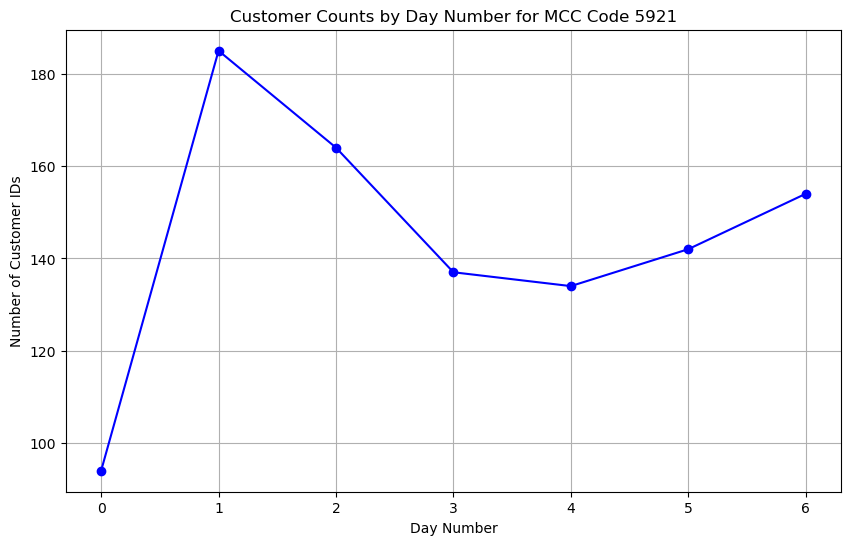

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Укажите нужный mcc_code
selected_mcc_code = 5921

# Фильтрация данных по выбранному mcc_code
df_filtered = df[df['mcc_code'] == selected_mcc_code]

# Извлечение первых 7 чисел до пробела в 'tr_datetime'
df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0][:6]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df_filtered.groupby('day_number')['customer_id'].nunique()

# Циклическое добавление количества пользователей каждый восьмой день к предыдущим дням
for i in range(7, daily_customer_counts.index.max() + 1):
    daily_customer_counts.loc[i - 6] += daily_customer_counts.loc[i]

# Оставляем только первые 7 дней
daily_customer_counts = daily_customer_counts.loc[:6]

# Построение графика
plt.figure(figsize=(10, 6))
daily_customer_counts.plot(marker='o', linestyle='-', color='b')
plt.title(f'Customer Counts by Day Number for MCC Code {selected_mcc_code}')
plt.xlabel('Day Number')
plt.ylabel('Number of Customer IDs')
plt.grid(True)
plt.show()

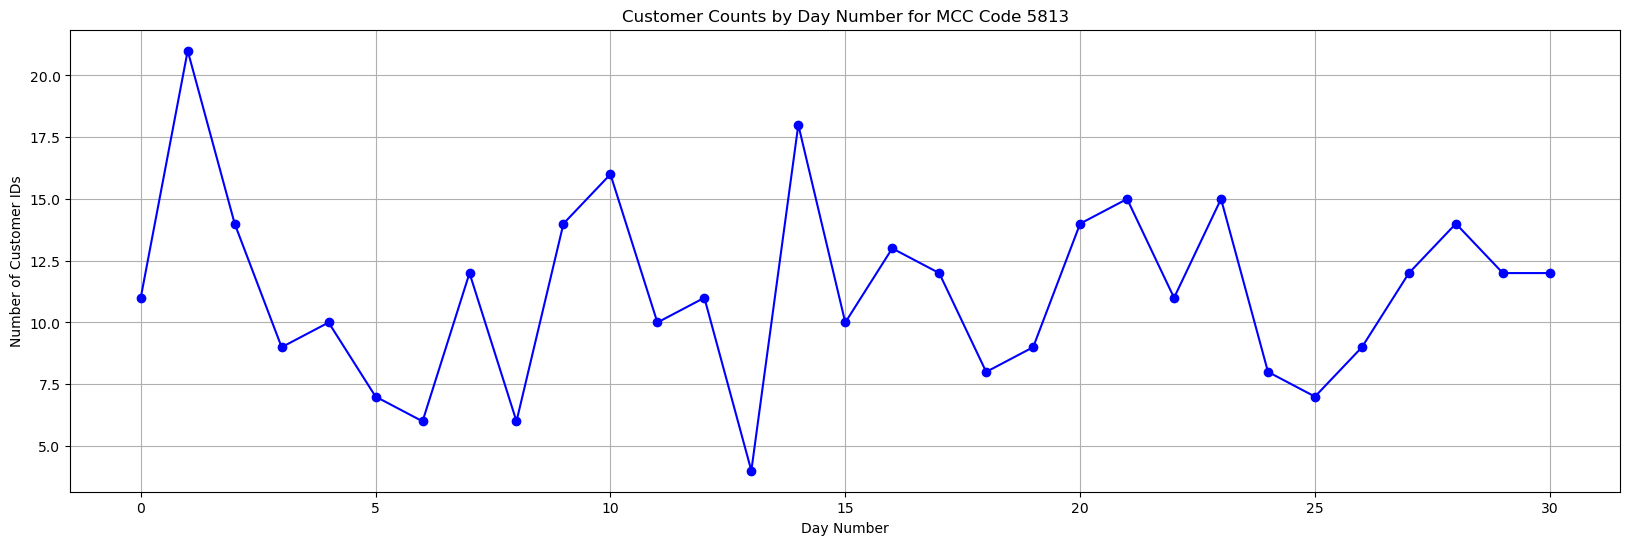

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Укажите нужный mcc_code
selected_mcc_code = 5813

# Фильтрация данных по выбранному mcc_code
df_filtered = df[df['mcc_code'] == selected_mcc_code]

# Извлечение первых 7 чисел до пробела в 'tr_datetime'
df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0][:31]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df_filtered.groupby('day_number')['customer_id'].nunique()

# Найти индекс дня, соответствующего 153 дню в году
index_153rd_day = (daily_customer_counts.index - 153).to_series().abs().idxmin()

# Создание нового индекса для графика с учетом 153 дня как первого дня
new_index = range(index_153rd_day, index_153rd_day + 31)

# Построение графика
plt.figure(figsize=(20, 6))
daily_customer_counts.loc[new_index].plot(marker='o', linestyle='-', color='b')
plt.title(f'Customer Counts by Day Number for MCC Code {selected_mcc_code}')
plt.xlabel('Day Number')
plt.ylabel('Number of Customer IDs')
plt.grid(True)
plt.show()





**Год 2008 либо 2014 один из которых високосный** 

In [9]:
df = transactions

# Разделение строки по пробелу и создание нового столбца
df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразование значения в числовой формат
df['day_number'] = df['day_number'].astype(int)

# Группировка данных по 'day_number' и подсчет количества транзакций
transaction_counts = df.groupby('day_number').size()

# Фильтрация номеров дней, где было больше 15000 транзакций
days_with_more_than_15000 = transaction_counts[transaction_counts > 15000].index

print("Номера дней с более чем 15000 транзакций:", days_with_more_than_15000)

# Фильтрация номеров дней, где было меньше 10000 транзакций
days_with_less_than_10000 = transaction_counts[transaction_counts < 10000].index
print("Номера дней с менее чем 10000 транзакций:", days_with_less_than_10000)

Номера дней с более чем 15000 транзакций: Index([ 91, 102, 103, 105, 111, 112, 119, 126, 131, 132,
       ...
       446, 447, 448, 449, 451, 452, 453, 454, 455, 456],
      dtype='int32', name='day_number', length=231)
Номера дней с менее чем 10000 транзакций: Index([2, 9, 16, 23, 37, 65, 153, 154, 155, 156, 159, 160, 163], dtype='int32', name='day_number')


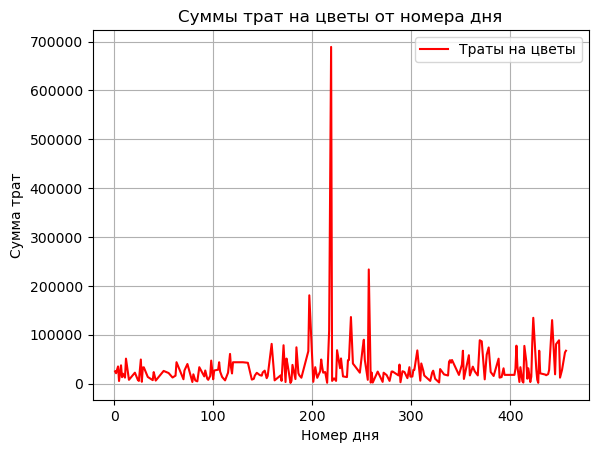

In [12]:
# Filter transactions with mcc_code equal to 5193 and negative amounts
filtered_transactions = df[(df['mcc_code'] == 5193) & (df['amount'] < 0)]

# Create a new DataFrame with day_number and the sum of negative amounts
March = filtered_transactions.groupby('day_number')['amount'].sum()

# Make the negative amounts positive
March = March.abs()

plt.plot(March.index, March.values, label='Траты на цветы', linestyle='-', color='r')

plt.title('Cуммы трат на цветы от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Нахождение дней, в которые сумма трат была больше 1.2
flover_time = March[March > 600000].index

print("8 марта:", flover_time)

8 марта: Index([219], dtype='int32', name='day_number')


**Значит между 8 марта и 1 января 219-153=66 дней, следовательно год 2014 так следующий год за началом отсчета не високосный**

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18200\1268301754.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0][:31]))


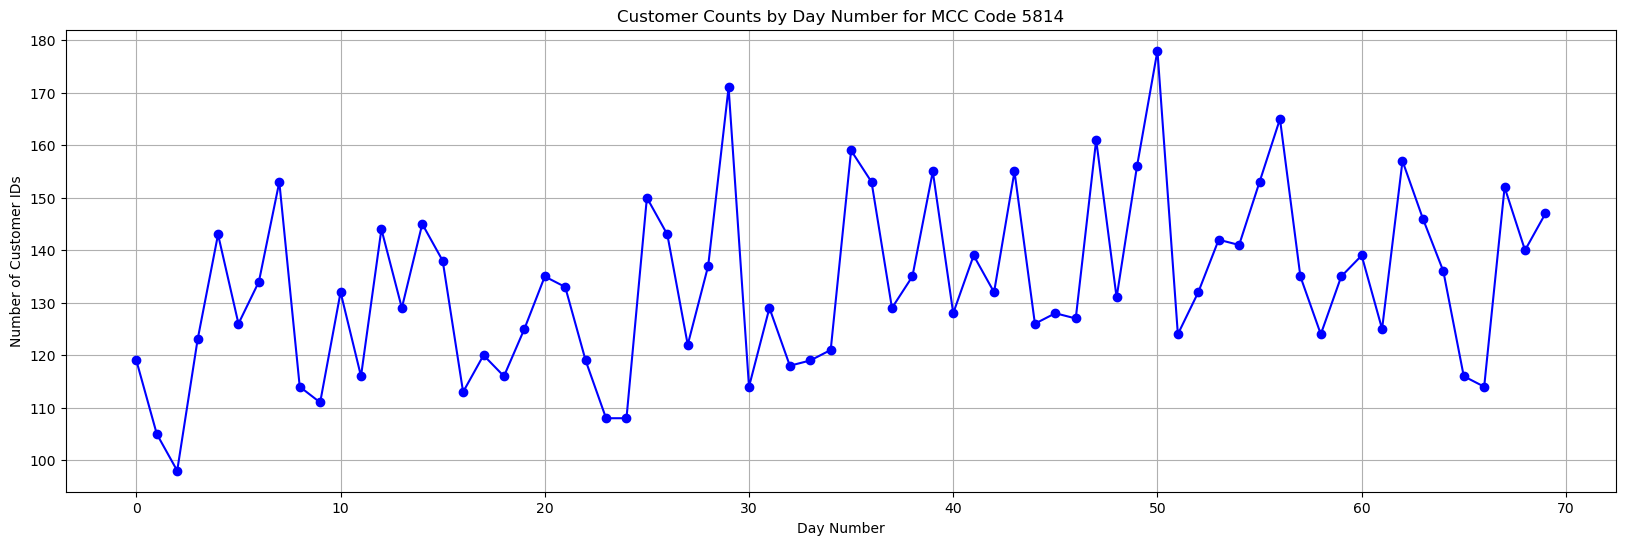

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('./data/transactions.csv')

# Укажите нужный mcc_code
selected_mcc_code = 5814

# Фильтрация данных по выбранному mcc_code
df_filtered = df[df['mcc_code'] == selected_mcc_code]

# Извлечение первых 7 чисел до пробела в 'tr_datetime'
df_filtered['day_number'] = df_filtered['tr_datetime'].apply(lambda x: int(x.split()[0][:31]))

# Группировка по числу и подсчет уникальных 'customer_id'
daily_customer_counts = df_filtered.groupby('day_number')['customer_id'].nunique()

# Найти индекс дня, соответствующего 153 дню в году
index_153rd_day = (daily_customer_counts.index - 153).to_series().abs().idxmin()

# Создание нового индекса для графика с учетом 153 дня как первого дня
new_index = range(index_153rd_day, index_153rd_day + 70)

# Построение графика
plt.figure(figsize=(20, 6))
daily_customer_counts.loc[new_index].plot(marker='o', linestyle='-', color='b')
plt.title(f'Customer Counts by Day Number for MCC Code {selected_mcc_code}')
plt.xlabel('Day Number')
plt.ylabel('Number of Customer IDs')
plt.grid(True)
plt.show()

In [98]:
import pandas as pd

# Загрузка данных из CSV файла
data = pd.read_csv('./data/transactions.csv')

desired_mcc_code = 9222
filtered_data = data[data['mcc_code'] == desired_mcc_code]

# Топ-5 ближайших к нулю значений amount
top_5_closest_to_zero = filtered_data.loc[filtered_data['amount'].abs().sort_values().index[:5]]

# Вывод результатов
print(top_5_closest_to_zero[['customer_id', 'tr_datetime', 'amount', 'term_id']])

         customer_id   tr_datetime   amount   term_id
6257257     83378138   18 11:50:36   -18.87       NaN
929394      75474815  290 01:53:28  -539.02    353569
1652440     73067127   47 00:00:00  -763.61       NaN
3875986      8816632  409 00:00:00  -824.70  20820801
5567039     24062324  272 17:47:27 -1347.55    353570


In [99]:
import pandas as pd

# Загрузка данных из CSV файла
data = pd.read_csv('./data/transactions.csv')

# Выбор данных для конкретного mcc_code
desired_mcc_code = 9222
filtered_data = data[data['mcc_code'] == desired_mcc_code]

# Топ-5 наиболее популярных значений amount
top_5_popular_amount = filtered_data['amount'].value_counts().head(5)

# Вывод результатов
print(top_5_popular_amount)


amount
-11678.76     102
-11454.17      89
-22908.34      31
-11903.35      21
-114541.70     17
Name: count, dtype: int64


In [100]:
import pandas as pd

# Загрузка данных из CSV файла
data = pd.read_csv('./data/transactions.csv')

# Выбор данных для конкретного mcc_code
desired_mcc_code = 9222
filtered_data = data[data['mcc_code'] == desired_mcc_code]

# Топ-5 минимальных значений amount
top_5_min_amount = filtered_data.nsmallest(5, 'amount')

# Вывод результатов
print(top_5_min_amount[['customer_id', 'tr_datetime', 'amount', 'term_id']])


         customer_id   tr_datetime      amount   term_id
967964      19368278  241 13:36:38 -1920611.04    809359
2064255     22370499  303 00:00:00  -687250.23  24810010
536448      57546321  137 00:00:00  -469620.99       NaN
1480190     26042080   11 00:00:00  -281772.59       NaN
2014475     39819120  213 00:00:00  -251991.75  43703204


In [102]:
import pandas as pd

# Загрузка данных из CSV файла
data = pd.read_csv('./data/transactions.csv')

# Выбор данных для конкретного mcc_code
desired_mcc_code = 5462
filtered_data = data[data['mcc_code'] == desired_mcc_code]

# Топ-5 наибольших значений amount
top_5_largest_amount = filtered_data.nlargest(5, 'amount')

# Вывод результатов
print(top_5_largest_amount[['customer_id', 'tr_datetime', 'amount', 'term_id']])


         customer_id   tr_datetime  amount term_id
5673881     50068531  268 22:40:49 -112.30  034968
2123666     81469705    8 13:38:58 -224.59     NaN
3573816      7443671  440 10:52:12 -224.59  514115
4984080     67228612  186 09:20:04 -224.59     NaN
5133108     81780909  100 08:03:53 -224.59     NaN


In [3]:
packet = 112.30/5
print(packet)

22.46


In [16]:
filtered_amounts = df[(df['tr_type'] == 2010) & (df['amount'] < 0)]['amount']
unique_amounts = filtered_amounts.unique()
sorted_unique_amounts = pd.Series(unique_amounts).astype(float).sort_values()
differences = sorted_unique_amounts.diff()
print(differences)
differences_counts = differences.value_counts()

# топ-10 самых частых разностей
top_10_differences = differences_counts.head(10)
print("Топ-10 самых частых разностей:")
print(top_10_differences)

661          NaN
206     36755.54
566     89836.63
272     22459.15
1207    67377.48
          ...   
0        1122.96
962        94.78
112      1028.18
46       1122.95
21       1122.96
Length: 1332, dtype: float64
Топ-10 самых частых разностей:
2245.92     146
2245.92      85
2245.91      75
2245.91      69
1122.96      68
1122.96      64
4491.83      54
1122.96      39
11229.58     38
2245.91      37
Name: count, dtype: int64


In [18]:
coefficient = differences_counts.idxmax()

print(f'Купюра домноженная на коэффициент {coefficient}')

Купюра домноженная на коэффициент 2245.9199999999255


**Поскольку видно еще купюры номиналом 1122.96 и 4491.83 Купюра 2245.91 является 1000 рублей, следовательно коэффициент 22.4591**

**0 - Женский пол, 1 - Мужской пол
Начало 1 августа 2014 года
Коэффициент 22.4591**